### Tahap 1: Setup dan Data Preprocessing

In [53]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# 1. Memuat Data
df = pd.read_csv("electronics_product.csv")
df.head()

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965,"₹10,999","₹18,999"
1,1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,"113,956","₹18,999","₹19,999"
2,2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,"90,304","₹1,999","₹2,299"
3,3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,"24,863","₹15,999","₹24,999"
4,4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,"113,956","₹18,999","₹19,999"


In [55]:
# 2. Data Cleaning dan Feature Engineering
print("--- Initial Data Info ---")
print(df.info())


--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      9600 non-null   int64 
 1   name            9600 non-null   object
 2   main_category   9600 non-null   object
 3   sub_category    9600 non-null   object
 4   image           9600 non-null   object
 5   link            9600 non-null   object
 6   ratings         9505 non-null   object
 7   no_of_ratings   9505 non-null   object
 8   discount_price  9116 non-null   object
 9   actual_price    9530 non-null   object
dtypes: int64(1), object(9)
memory usage: 750.1+ KB
None


In [56]:
# Fungsi untuk membersihkan kolom mata uang (menghapus '₹' dan koma)
def clean_currency(price_series):
    return price_series.astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False).str.strip()

# Cleaning Harga
df['discount_price_clean'] = pd.to_numeric(clean_currency(df['discount_price']), errors='coerce')
df['actual_price_clean'] = pd.to_numeric(clean_currency(df['actual_price']), errors='coerce')

# Cleaning Rating dan Jumlah Rating
df['ratings_clean'] = pd.to_numeric(df['ratings'].astype(str).str.replace('Out of 5 Stars', '', regex=False).str.strip(), errors='coerce')
df['no_of_ratings_clean'] = pd.to_numeric(df['no_of_ratings'].astype(str).str.replace(',', '', regex=False).str.strip(), errors='coerce')

# Menghitung Persentase Diskon (Fitur Engineering)
df['discount_percentage'] = (
    (df['actual_price_clean'] - df['discount_price_clean']) / df['actual_price_clean']
) * 100
# Handle case where actual_price is 0 or discount_percentage is negative
df.loc[df['discount_percentage'] < 0, 'discount_percentage'] = 0
df.loc[df['actual_price_clean'] == 0, 'discount_percentage'] = 0

# Menggunakan log-transform untuk Jumlah Rating (Popularitas)
df['log_no_of_ratings'] = np.log1p(df['no_of_ratings_clean'])

# Drop baris dengan nilai kritis yang hilang
critical_cols = ['ratings_clean', 'discount_price_clean', 'log_no_of_ratings']
df_clean = df.dropna(subset=critical_cols).copy()

print(f"Jumlah Data Bersih: {len(df_clean)}")
df_clean

Jumlah Data Bersih: 9002


,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,discount_price_clean,actual_price_clean,ratings_clean,no_of_ratings_clean,discount_percentage,log_no_of_ratings
0,0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965,"₹10,999","₹18,999",10999.0,18999.0,4.0,965.0,42.107479,6.873164
1,1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,"113,956","₹18,999","₹19,999",18999.0,19999.0,4.3,113956.0,5.000250,11.643576
2,2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,"90,304","₹1,999","₹2,299",1999.0,2299.0,4.2,90304.0,13.049152,11.410948
3,3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,"24,863","₹15,999","₹24,999",15999.0,24999.0,4.1,24863.0,36.001440,10.121176
4,4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,"113,956","₹18,999","₹19,999",18999.0,19999.0,4.3,113956.0,5.000250,11.643576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,9595,PALAY® BTS Backpack For Boys Kpop BTS Bangtan ...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51WpV43F1M...,https://www.amazon.in/PALAY%C2%AE-Backpack-Ban...,4.1,37,"₹1,710","₹2,491",1710.0,2491.0,4.1,37.0,31.352870,3.637586
9596,9596,MOCA iPad Air 5th Generation Case 2022 / iPad ...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/31lmoZ3XWQ...,https://www.amazon.in/MOCA-Protective-Generati...,4.2,"1,133",₹475,"₹1,999",475.0,1999.0,4.2,1133.0,76.238119,7.033506
9597,9597,ZEBRONICS Zeb-Sound Bomb 5 TWS V5.0 Bluetooth ...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/61O7fCXFip...,https://www.amazon.in/Zebronics-Zeb-Sound-Blue...,3.5,"3,177",₹962,"₹3,999",962.0,3999.0,3.5,3177.0,75.943986,8.064007
9598,9598,LINQS® Original NXP Chip | Waterproof NFC Tag ...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71Sg1Qsf+4...,https://www.amazon.in/LINQS-Sticker-Smartrac-C...,3.6,210,₹400,"₹1,000",400.0,1000.0,3.6,210.0,60.000000,5.351858


### Tahap 2: K-Means Clustering (Segmentasi Pasar)

In [57]:
# 3. Persiapan Fitur Clustering
X_cols = ['discount_price_clean', 'discount_percentage', 'log_no_of_ratings']
X = df_clean[X_cols]
X

,discount_price_clean,discount_percentage,log_no_of_ratings
0,10999.0,42.107479,6.873164
1,18999.0,5.000250,11.643576
2,1999.0,13.049152,11.410948
3,15999.0,36.001440,10.121176
4,18999.0,5.000250,11.643576
...,...,...,...
9595,1710.0,31.352870,3.637586
9596,475.0,76.238119,7.033506
9597,962.0,75.943986,8.064007
9598,400.0,60.000000,5.351858


In [58]:
# Scaling Fitur (Penting untuk K-Means)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[0.08140663, 0.43014663, 0.50260251],
       [0.14067072, 0.05106475, 0.89056609],
       [0.01473453, 0.13329112, 0.87164711],
       ...,
       [0.00705243, 0.77581531, 0.5994503 ],
       [0.00288912, 0.61293394, 0.37887921],
       [0.00688945, 0.16416625, 0.50029702]])

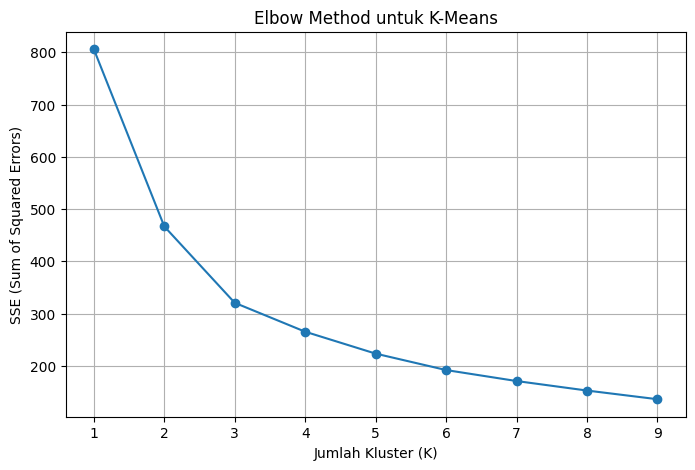

In [59]:
# 4. Menentukan Jumlah Kluster Optimal (Metode Elbow)
sse = [] # Sum of Squared Errors
k_range = range(1, 10)
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_scaled)
    sse.append(kmeans_model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method untuk K-Means')
plt.xlabel('Jumlah Kluster (K)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.grid(True)
plt.show()

In [60]:
# Berdasarkan hasil visualisasi (asumsi K=3 optimal untuk demonstrasi)
K = 3
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nClusterisasi Selesai dengan K={K} \n")
cluster_summary = df_clean.groupby('Cluster')[['discount_price_clean', 'discount_percentage', 'ratings_clean', 'log_no_of_ratings']].mean()
cluster_summary


Clusterisasi Selesai dengan K=3 



,discount_price_clean,discount_percentage,ratings_clean,log_no_of_ratings
Cluster,,,,
0,1178.194492,64.583312,4.081117,8.537901
1,1064.825732,64.886498,3.994652,4.595062
2,7076.982084,25.343949,4.139419,7.555466


In [61]:
df_zoom.columns

Index(['Unnamed: 0', 'name', 'main_category', 'sub_category', 'image', 'link',
       'ratings', 'no_of_ratings', 'discount_price', 'actual_price',
       'discount_price_clean', 'actual_price_clean', 'ratings_clean',
       'no_of_ratings_clean', 'discount_percentage', 'log_no_of_ratings',
       'Cluster'],
      dtype='object')

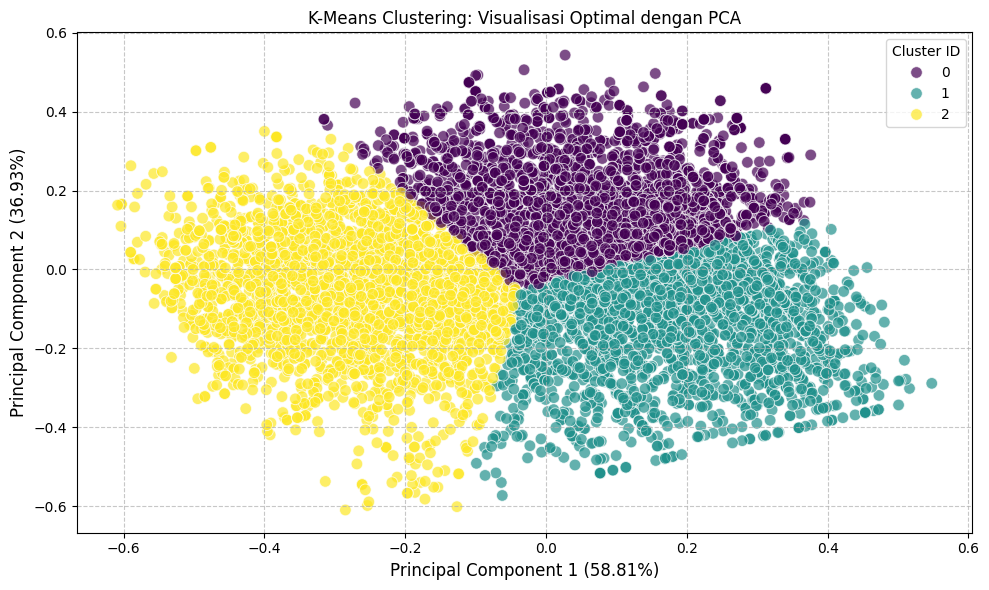

In [62]:
# Visualisasi Clustering
from sklearn.decomposition import PCA

# Terapkan PCA ke Data yang Sudah di-Scale
# Reduksi 3 fitur (Harga, Diskon, Popularitas) menjadi 2 komponen utama.
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled) # X_scaled dari cell 54

# Buat DataFrame Baru untuk Visualisasi
df_pca = pd.DataFrame(
    data = principal_components,
    columns = ['Principal Component 1', 'Principal Component 2']
)

# Tambahkan label Kluster ke DataFrame PCA
df_pca['Cluster'] = df_clean['Cluster'].values

# Hitung Variansi yang Dijelaskan oleh PC1 dan PC2
# Ini penting untuk label plot
variance_explained = pca.explained_variance_ratio_
pc1_var = round(variance_explained[0] * 100, 2)
pc2_var = round(variance_explained[1] * 100, 2)

# Visualisasi Klaster pada PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='Cluster',
    data=df_pca,
    palette='viridis',
    s=70,
    alpha=0.7
)

plt.title('K-Means Clustering: Visualisasi Optimal dengan PCA')
plt.xlabel(f'Principal Component 1 ({pc1_var}%)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pc2_var}%)', fontsize=12)
plt.legend(title='Cluster ID')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Tahap 3: Analisis SPK dengan SAW (Simple Additive Weighting)

In [63]:
# 6. SAW: Penetapan Bobot Kriteria Berdasarkan Hasil Clustering
# Kita akan fokus pada Kluster 0 (Value for Money/Anggaran)
# Di segmen ini, Kriteria HARGA dan RATING sangat penting bagi konsumen.
cluster_target_id = 0
df_target = df_clean[df_clean['Cluster'] == cluster_target_id].copy()

# Filter untuk mendapatkan data yang lebih relevan untuk MADM (misal: produk dengan rating > 3.5)
df_target = df_target[df_target['ratings_clean'] > 3.5].head(50) # Ambil 50 produk teratas
df_target.head()


,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,discount_price_clean,actual_price_clean,ratings_clean,no_of_ratings_clean,discount_percentage,log_no_of_ratings,Cluster
6,6,boAt Airdopes 141 Bluetooth Truly Wireless in ...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51HBom8xz7...,https://www.amazon.in/Airdopes-141-Playtime-Re...,3.9,"172,347","₹1,299","₹3,995",1299.0,3995.0,3.9,172347.0,67.484355,12.057271,0
8,8,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/61S9aVnRZD...,https://www.amazon.in/Fire-Boltt-Bluetooth-Cal...,4.3,"16,949","₹1,799","₹19,999",1799.0,19999.0,4.3,16949.0,91.004550,9.738023,0
13,13,boAt Airdopes Atom 81 True Wireless in Ear Ear...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51NKpc-CnB...,https://www.amazon.in/boAt-Airdopes-Atom-81-Wi...,3.8,"3,327","₹1,299","₹4,490",1299.0,4490.0,3.8,3327.0,71.069042,8.110127,0
14,14,boAt Airdopes 141 Bluetooth Truly Wireless in ...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51tFAbNRaP...,https://www.amazon.in/Airdopes-141-Bluetooth-W...,3.9,"172,347","₹1,299","₹4,490",1299.0,4490.0,3.9,172347.0,71.069042,12.057271,0
15,15,boAt BassHeads 100 in-Ear Wired Headphones wit...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/719elVA3Fv...,https://www.amazon.in/boAt-BassHeads-100-Headp...,4.1,"375,110",₹399,₹999,399.0,999.0,4.1,375110.0,60.060060,12.834977,0


In [64]:
# Definisi Kriteria dan Bobot SPK (Berubah berdasarkan Segmen Pasar)
criteria = {
    'ratings_clean': {'type': 'benefit', 'weight': 0.40},       # Rating: Paling penting (40%)
    'discount_price_clean': {'type': 'cost', 'weight': 0.35},    # Harga: Sangat penting (35%)
    'log_no_of_ratings': {'type': 'benefit', 'weight': 0.15},   # Popularitas: Cukup penting (15%)
    'discount_percentage': {'type': 'benefit', 'weight': 0.10}  # Diskon: Pelengkap (10%)
}
weights = np.array([criteria[col]['weight'] for col in criteria.keys()])

In [65]:
# Fungsi Normalisasi SAW (Max untuk Benefit, Min untuk Cost)
def normalize_saw(series, criterion_type):
    if criterion_type == 'benefit':
        # Normalisasi: X_ij / Max(X_ij)
        return series / series.max()
    elif criterion_type == 'cost':
        # Normalisasi: Min(X_ij) / X_ij
        return series.min() / series
    return series

# 7. Proses SAW

df_saw_normalized = pd.DataFrame()
for col, prop in criteria.items():
    df_saw_normalized[f'Normalized_{col}'] = normalize_saw(df_target[col], prop['type'])
df_saw_normalized

,Normalized_ratings_clean,Normalized_discount_price_clean,Normalized_log_no_of_ratings,Normalized_discount_percentage
6,0.866667,0.045420,0.939407,0.734389
8,0.955556,0.032796,0.758710,0.990344
13,0.844444,0.045420,0.631877,0.773398
14,0.866667,0.045420,0.939407,0.773398
15,0.911111,0.147870,1.000000,0.653595
16,0.911111,0.053685,0.907853,0.788493
17,0.933333,0.608247,0.517428,0.982571
18,0.844444,0.029515,0.783273,0.815972
20,0.844444,0.053685,0.946193,0.688245
27,0.911111,0.039360,0.927976,0.679397


In [66]:
# 8. Menghitung Nilai Preferensi (V) / Vektor S
# V_i = Sum (W_j * r_ij)
df_saw_normalized['SAW_Score'] = (df_saw_normalized.iloc[:, 0:len(criteria)].values * weights).sum(axis=1)
df_saw_normalized['SAW_Score']

6      0.576913
8      0.606542
13     0.525796
14     0.580814
15     0.631558
16     0.598262
17     0.762091
18     0.547196
20     0.567321
27     0.585356
28     0.592932
32     0.653298
33     0.619817
34     0.560244
39     0.580814
41     0.532077
42     0.579383
46     0.627993
48     0.589507
54     0.560825
55     0.769412
56     0.634931
57     0.554191
58     0.617146
59     0.608014
61     0.826718
62     0.599871
65     0.645231
66     0.582716
67     0.584217
69     0.599896
71     0.582100
74     0.852414
75     0.619382
76     0.622160
77     0.624071
78     0.520617
79     0.621690
81     0.601921
84     0.568159
85     0.542074
88     0.563673
89     0.587035
93     0.524484
94     0.579440
96     0.627993
98     0.596242
100    0.649803
101    0.560825
102    0.629204
Name: SAW_Score, dtype: float64

In [69]:
# 9. Final Ranking
df_target['SAW_Score'] = df_saw_normalized['SAW_Score']
df_final_ranking = df_target.sort_values(by='SAW_Score', ascending=False)

# 10. Output Hasil SPK

print(f"\n--- Top 10 Produk Terbaik di Kluster {cluster_target_id} (Segmen Value for Money) ---")
print(f"Bobot Kriteria: Rating={criteria['ratings_clean']['weight']}, Harga={criteria['discount_price_clean']['weight']}, Popularitas={criteria['log_no_of_ratings']['weight']}, Diskon={criteria['discount_percentage']['weight']}")

result_cols = ['name', 'ratings_clean', 'no_of_ratings_clean', 'discount_price_clean', 'SAW_Score']
print(df_final_ranking[result_cols].head(10).to_markdown(index=False, numalign="left", stralign="left"))


--- Top 10 Produk Terbaik di Kluster 0 (Segmen Value for Money) ---
Bobot Kriteria: Rating=0.4, Harga=0.35, Popularitas=0.15, Diskon=0.1
| name                                                                                                                          | ratings_clean   | no_of_ratings_clean   | discount_price_clean   | SAW_Score   |
|:------------------------------------------------------------------------------------------------------------------------------|:----------------|:----------------------|:-----------------------|:------------|
| OneAssist 1 Year Extended Warranty for Smartwatch up to 3000 - Email Delivery Within 2 Hours, No Physical Kit                 | 4               | 1387                  | 59                     | 0.852414    |
| LAPSTER Spiral Charger Spiral Charger Cable Protectors for Wires Data Cable Saver Charging Cord Protective Cable Cover Set... | 4.1             | 9742                  | 81                     | 0.826718    |
| STRIFF Mpad Mous